## Inferential regression

Thinking about the assumptions of linear regression.

1. Show the distribution of p-values
2. Now do it again for a random walk
3. Now do it again for non-normal errors



In [207]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from scipy.special import expit, logit
%matplotlib inline

In [52]:
npts = 3
beta0 = 1
beta1 = 0

In [5]:
x = stats.uniform(0, 10).rvs(npts)
y = beta0 + beta1 * x + stats.norm(0, 1).rvs(npts)

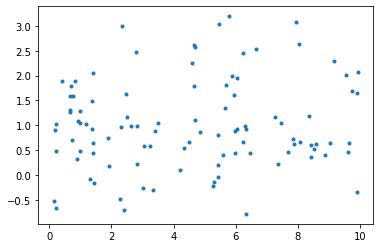

In [6]:
fig, ax = plt.subplots()
ax.plot(x, y, '.')

In [19]:
x = sm.add_constant(x)

In [20]:
model = sm.OLS(y, x)
results = model.fit()

In [23]:
results.pvalues[1]

0.27453402584182657

ok, now loop it.

It's a little ugly using kdes on bounded data, so we're transforming the variables following http://thirdorderscientist.org/homoclinic-orbit/2013/10/24/kernel-density-estimation-for-random-variables-with-bounded-support-mdash-the-transformation-trick

In [305]:
def bounded_kde(dataset):
    """return a gaussian kde function bounded (for now) between 0 and 1, in 1 dimension"""
    kde = stats.gaussian_kde(logit(dataset))
    return lambda x: kde(logit(x))/(x*(1-x))

In [335]:
def sample_pvalues(xfunc, yfunc, npts=100, ntrials=10000):
    """
       xfunc :   function taking 1 argument (npts); returns that many x values
       yfunc :   function taking 1 argument (x); returns corresponding y values
       npts :    number of points to get
       ntrials : number of p-values to calculate"""
    pvalues = []
    for _ in range(ntrials):
        x = xfunc(npts)
        y = yfunc(x)
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()
        pvalues.append(results.pvalues[1])
    return pvalues

In [406]:
def hist_pvalues(ax, pvalues, bins=50):
    ax.hist(pvalues, bins=bins, density=True, alpha=0.5, label='histogram of pvalues');
    ax.set_xlabel('p-value')
    ax.set_title(f'Distribution of p-values of $\\beta_1$ of linear regression')
    kde = bounded_kde(pvalues)
    # skip endpoints because it gives an error
    # (though it probably has a limit somewhere?)
    ps = np.linspace(0, 1, 200)[1:-1]
    ax.plot(ps, kde(ps), 'r', label='bounded kde')
    ax.plot([0,1], [1,1], 'k:', label='expected if p-value is FPR')
    ax.legend()

In [367]:
def draw_func(ax, xfunc, yfunc, npts, label=None):
    x = xfunc(npts)
    y = yfunc(x)
    ax.plot(x, y, '.', label=label)

In [374]:
def sample_and_show(xfunc, yfunc, npts=100, ntrials=1000):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    for i in range(3):
        draw_func(axs[0], xfunc, yfunc, npts, label=f'sample {i}')
    axs[0].legend()
   
    pvalues = sample_pvalues(xfunc,
                        yfunc,
                        npts=npts,
                        ntrials=ntrials)
    hist_pvalues(axs[1], pvalues)

## Assumptions met

In [402]:
xfunc = stats.uniform(0, 10).rvs
yfunc = lambda x: beta0 + beta1 * x + stats.norm(0, 1).rvs(len(x))

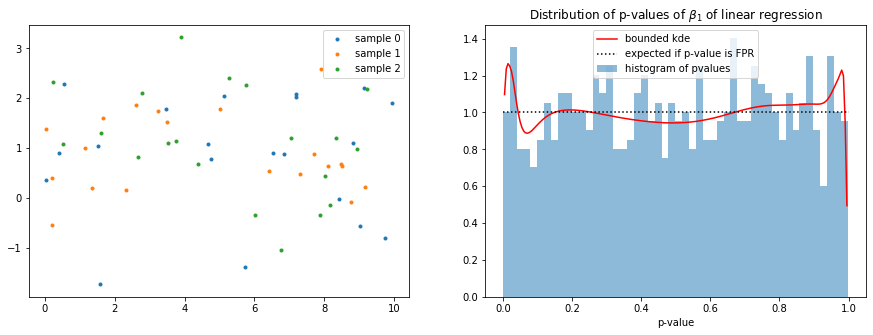

In [408]:
sample_and_show(xfunc, yfunc, 20, 1000)

The p-value, calculated by `statsmodels`, is the probability that, under the given null hypothesis (that the `y` values are normally distributed and independent of `x`), the beta coefficient would be as greater than or equal to what we actually saw. As we see, this is uniformly distributed...

We're 

In all of these cases the null

What this graph means is that the distribution of p-values is uniform, so that under this hypothesis

## Non-normal errors

Let's try with uniform rather than normal errors.

In [411]:
xfunc = stats.uniform(0, 10).rvs
yfunc = lambda x: beta0 + beta1 * x + stats.uniform(0, 1).rvs(len(x))

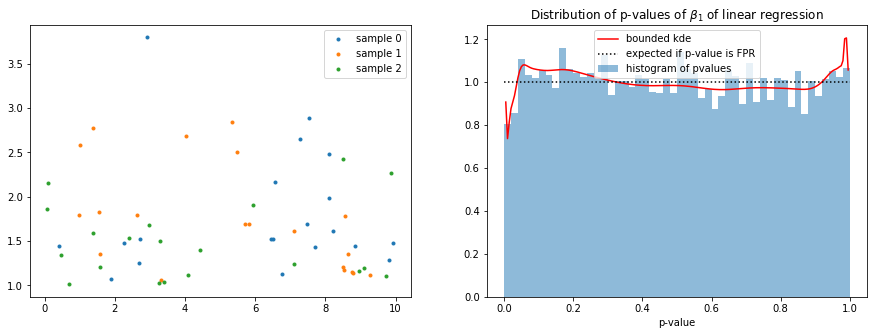

In [412]:
sample_and_show(xfunc, yfunc, 20, 10000)

Maybe something skewed and leptokurtic, like the exponential distribution?

In [413]:
xfunc = stats.uniform(0, 10).rvs
yfunc = lambda x: beta0 + beta1 * x + stats.expon(0, 1).rvs(len(x))

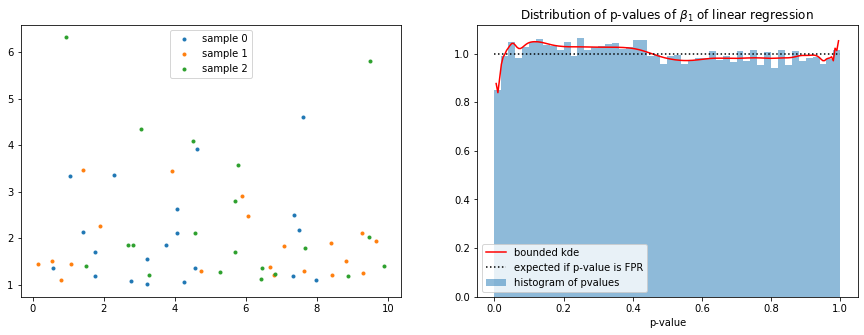

In [415]:
sample_and_show(xfunc, yfunc, 20, 100000)

That's not too bad. How about a crazy distribution?

In [379]:
xfunc = stats.uniform(0, 10).rvs
yfunc = lambda x: beta0 + beta1 * x + stats.cauchy(0, 1).rvs(len(x))

/Users/jackbennetto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


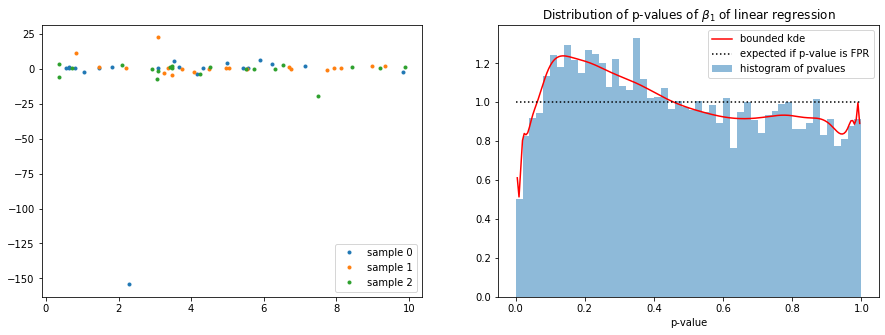

In [380]:
sample_and_show(xfunc, yfunc, 20, 10000)

Clearly that won't work.

## Random walk

What if we violate independence? A pretty extreme example is a random walk.

In [381]:
xfunc = lambda npts: np.linspace(0, 1, npts)
yfunc =  lambda x: stats.norm(0, 1).rvs(len(x)).cumsum()

/Users/jackbennetto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


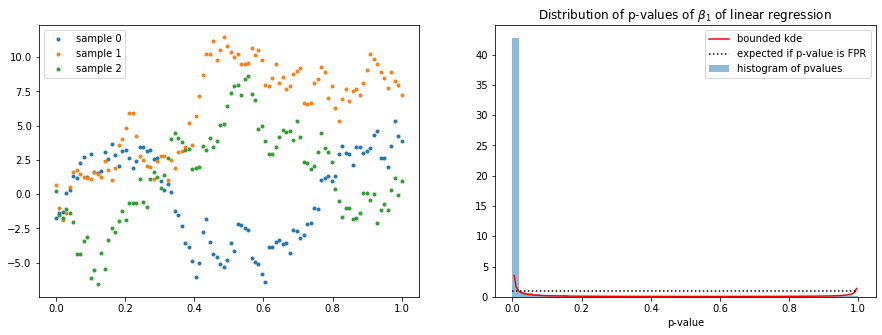

In [382]:
sample_and_show(xfunc, yfunc, 100, 10000)

Whoa. So random walk is bad.

Let's try a simple MA sequence.

In [383]:
xfunc = lambda npts: np.linspace(0, 1, npts)
def yfunc(x):
    y = stats.norm(0, 1).rvs(len(x) + 1)
    return y[1:] +  1 * y[:-1]

/Users/jackbennetto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


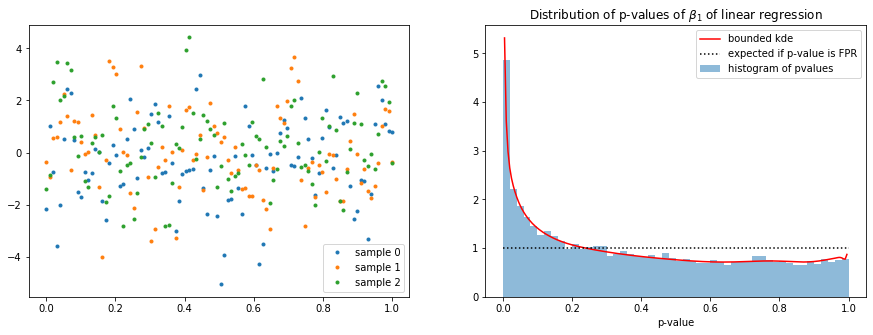

In [384]:
sample_and_show(xfunc, yfunc, 100, 10000)

## Heteroskedacity

In [424]:
xfunc = lambda npts: np.linspace(0, 1, npts)
yfunc = lambda x: stats.norm(0, 0.25-x+x**2).rvs(len(x))

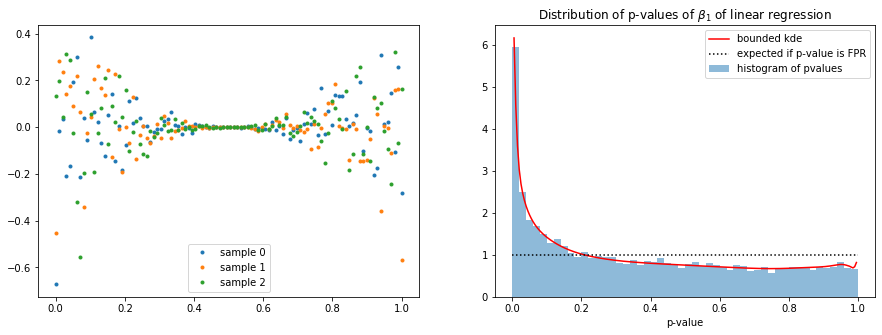

In [425]:
sample_and_show(xfunc, yfunc, 100, 10000)

## Non-linear

Here we add a quadratic term. Note that the it doesn't introduce an overall trend; we still expect the $\beta_1$ to be equal to 0.

In [392]:
xfunc = lambda npts: np.linspace(-1, 1, npts)
yfunc = lambda x: x**2 + stats.norm(0, .3).rvs(len(x))

/Users/jackbennetto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


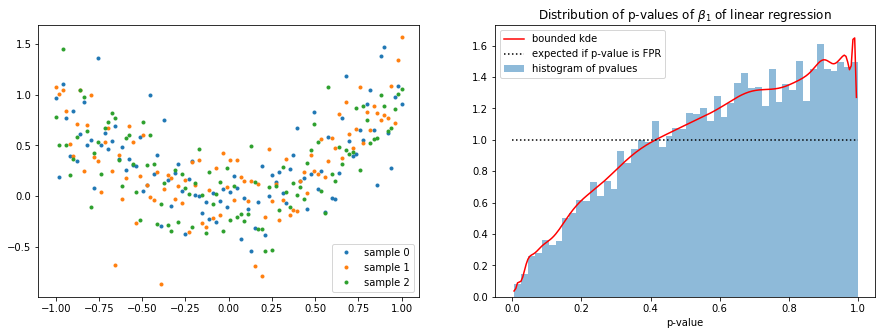

In [393]:
sample_and_show(xfunc, yfunc, 100, 10000)

## Correlated variable

In [342]:
npts = 20
xfunc = stats.uniform(0, 10).rvs
def yfunc(x):
    x2 = x + stats.norm(0, 1).rvs(len(x))
    return beta0 + 0.1 * x2 + stats.norm(0, 1).rvs(len(x))

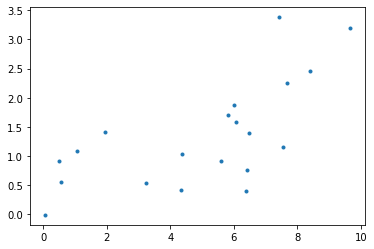

In [343]:
fig, ax = plt.subplots()
draw_func(ax, xfunc, yfunc, npts)

In [344]:
pvalues = sample_pvalues(xfunc,
                         yfunc,
                         npts)

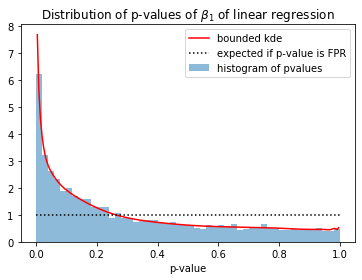

In [398]:
fig, ax = plt.subplots()
hist_pvalues(ax, pvalues)